Pre-elaborare i dati con scaling standard.

Ridurre la dimensionalità con PCA per
migliorare l'efficienza computazionale.

Utilizzare un modello di Gradient Boosting
Classifier.

Ottimizzare gli iperparametri con
RandomizedSearchCV.

Valutare le prestazioni utilizzando
StratifiedKFold per mantenere la proporzione
delle classi.

In [63]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from scipy.stats import randint as sp_randint
from scipy.stats import uniform


In [64]:

wine = load_wine()
X = wine.data
y = wine.target

In [65]:
#creo un df per il dataset wine dalle feature
wine_df = pd.DataFrame(data=wine.data, columns=wine.feature_names)
#ci aggiungo la colonna target "class"
wine_df['class'] = wine.target

wine_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    float64
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline                       178 non-null    float64
 13  class

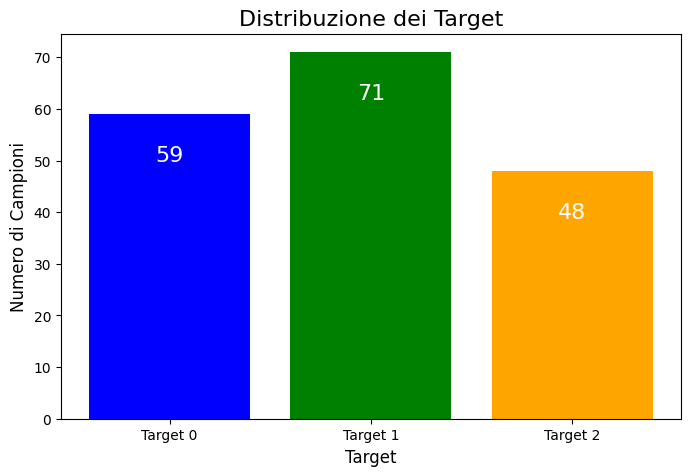

In [66]:
grouped = wine_df.groupby("class").size()

wine_df["class"].value_counts()

plt.figure(figsize=(8, 5))
bars = plt.bar(wine_df["class"].value_counts().index, wine_df["class"].value_counts().values, color=['green','blue','orange'])
plt.title('Distribuzione dei Target', fontsize=16)
plt.xlabel('Target', fontsize=12)
plt.ylabel('Numero di Campioni', fontsize=12)
plt.xticks(ticks=wine_df["class"].value_counts().index, labels=[f'Target {i}' for i in wine_df["class"].value_counts().index])
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval - 10,
             f'{int(yval)}', ha='center', va='bottom', fontsize=16, color='white')
plt.show()

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [68]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('gbc', GradientBoostingClassifier(random_state=42))
])

In [69]:
# Definizione della distribuzione dei parametri
param_dist = {
    'pca__n_components': [2,5,13],
    'gbc__n_estimators': [50,100,200],
    'gbc__learning_rate': uniform(0.01, 0.2),
    'gbc__max_depth': [1, 2, 3],
    'gbc__subsample': [0.4, 0.6],
    'gbc__min_samples_split': sp_randint(2, 10),
    'gbc__min_samples_leaf': sp_randint(1, 10)
}

In [70]:
# Configurazione della validazione incrociata stratificata
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Configurazione di RandomizedSearchCV
random_search = RandomizedSearchCV(
    pipeline, param_distributions=param_dist, n_iter=50, cv=cv,
    scoring='accuracy', random_state=42)

In [71]:
search = random_search.fit(X_train, y_train)

In [72]:
pipeline.set_params(**search.best_params_).fit(X_train, y_train).score(X_test, y_test)

1.0

              precision    recall  f1-score   support

     class_0       1.00      1.00      1.00        14
     class_1       1.00      1.00      1.00        14
     class_2       1.00      1.00      1.00         8

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36



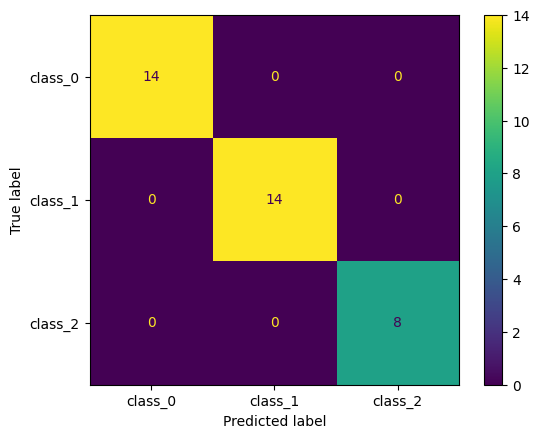

In [73]:
model_opt = random_search.best_estimator_

model_opt.fit(X_train, y_train)

y_pred_new = model_opt.predict(X_test)

class_report_new = classification_report(y_test, y_pred_new, target_names = wine.target_names)
print(class_report_new)

cm_new = confusion_matrix(y_test, y_pred_new)
cm_display_new = ConfusionMatrixDisplay(confusion_matrix = cm_new, display_labels=wine.target_names)
cm_display_new.plot()
plt.show()